In [1]:
from build_cluster import Cluster
import nest
import numpy as np
import yaml
import matplotlib.pyplot as plt
import evaluation_BN as ev


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Creating clutser

In [2]:
# Load the YAML configuration once
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
nest.ResetKernel()
# Create BN instance
bn = Cluster(config=config)
bn.build_one_cluster()
# bn.add_input() # Only if you set with_input=True, it will add input, otherwise it prints that no input is added
bn.run_simulation()
# bn.plot_results()

Network built successfully with heterogeneous parameters ['g_L'].

Jan 07 20:58:54 NodeManager::prepare_nodes [Info]: 
    Preparing 64 nodes for simulation.

Jan 07 20:58:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 64
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 07 20:58:55 SimulationManager::run [Info]: 
    Simulation finished.
Simulation completed!


## Evaluation 

### 1. E/I currents
using: \
$I_{ex}(t) = g_{ex}(t) * (E_{ex} - V_{m}(t))$ \
$I_{in}(t) = g_{in}(t) * (E_{in} - V_{m}(t))$ 

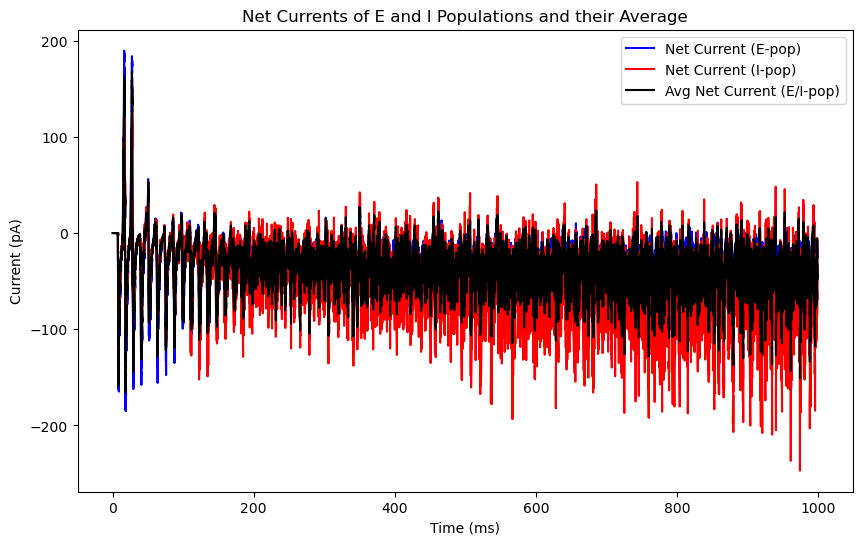

In [4]:
# Suppose bn.m_e is the multimeter for excitatory pops and bn.m_i for inhibitory pops
pyr_data = nest.GetStatus(bn.m_e, keys='events')[0]
pv_data = nest.GetStatus(bn.m_i, keys='events')[0]

# You know N_e and N_i from config (e.g., bn.str_dict['N_e'] and bn.str_dict['N_i'])
N_e = bn.str_dict['N_e']
N_i = bn.str_dict['N_i']

times, I_ex_e, I_in_e, I_ex_i, I_in_i = ev.compute_EI_balance(pyr_data, pv_data, N_e, N_i, E_ex=bn.pyr_param['E_ex'], E_in=bn.pyr_param['E_in'])


### 2. Coefficient of variation of the Inter Spike Interval
First conputing the CV of ISI for each neuron, then the average CV of ISI for the whole cluster. Also plotting the histogram of the excitatory and inhibitory populations as that will show if it sollows a uniform distribution (quite balanced network like) or bimodal (if heterogeneous network and not balanced).

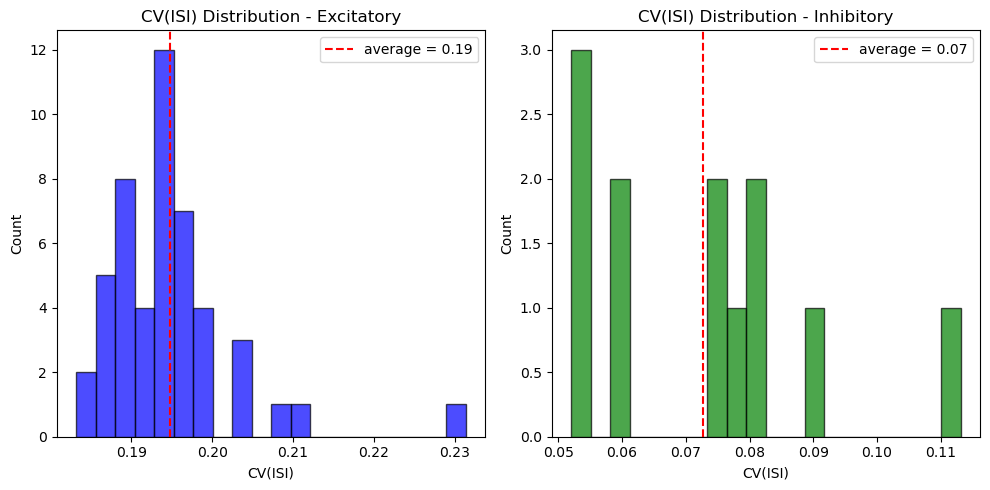

Average CV(ISI) - Pyramidal: 0.1948096810003951
Average CV(ISI) - PV: 0.07270770401199106


In [5]:
pyr_data = nest.GetStatus(bn.pyr_spikes, keys='events')[0]
pv_data = nest.GetStatus(bn.pv_spikes, keys='events')[0]

CV_pyr, CV_pv = ev.CV_ISI(pyr_data, pv_data)
print("Average CV(ISI) - Pyramidal:", CV_pyr)
print("Average CV(ISI) - PV:", CV_pv)

### 3. Cross-correlation function
computed at zero lag: means that we do not shift one spike train relative to the other. In other words, we compare their firing rates at exactly the same moments in time.

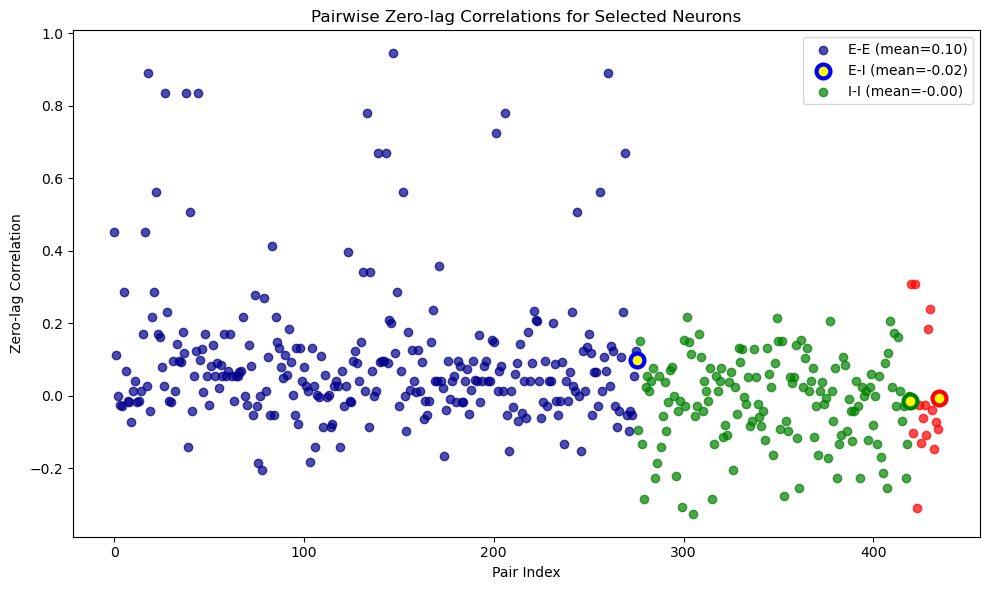

In [6]:
results = ev.compute_ccf_zero_lag(pyr_data, pv_data, bin_size=10.0, fraction=0.5)

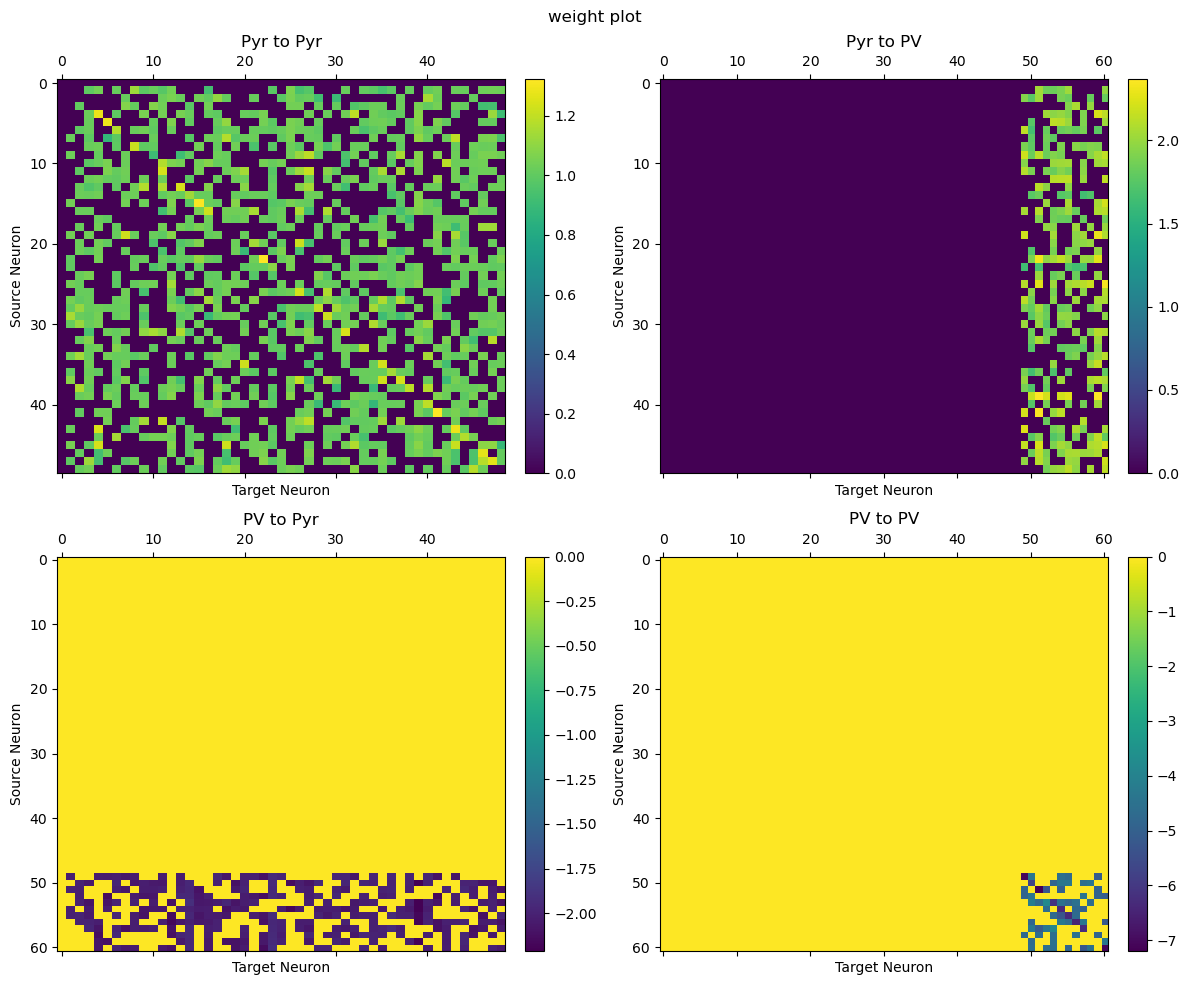

In [7]:
connections = [
    ("Pyr to Pyr", bn.pyr_neurons, bn.pyr_neurons, 221),
    ("Pyr to PV", bn.pyr_neurons, bn.pv_neurons, 222),
    ("PV to Pyr", bn.pv_neurons, bn.pyr_neurons, 223),
    ("PV to PV", bn.pv_neurons, bn.pv_neurons, 224),
]

ev.conn_weights(connections, 'weight plot')

#### Reasoning
There are huge outliers in some connection strenghts, hence the interquartile range plot as well for some quantification thereof. In the future, there should tho be a smarter weight limit implemented in the triplet STDP rule.

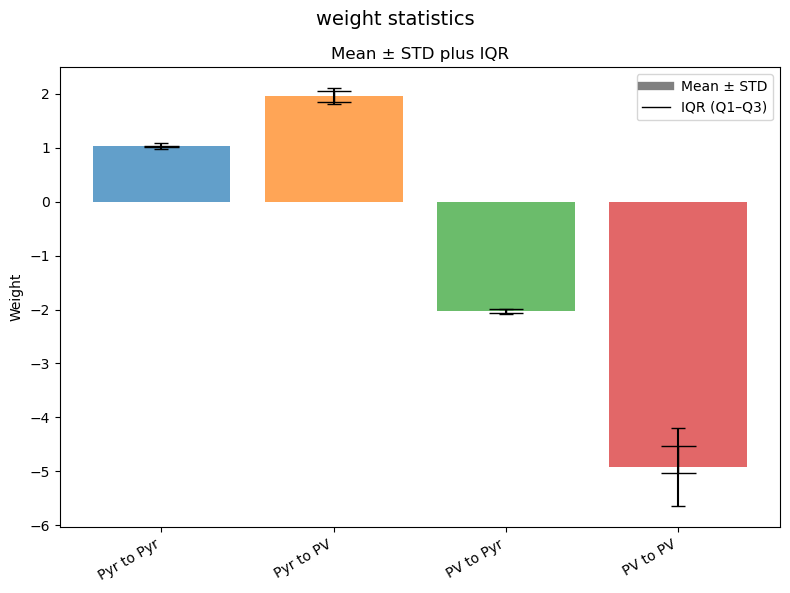

In [8]:
ev.plot_weight_statistics_with_iqr(connections, 'weight statistics')